---
***The 11th Computational Neuroscience Winter School***

# Tutorial I: Dimension Reduction - a dynamical variant of PCA: jPCA

__Date:__ Jan. 19, 2022

__Content Creator:__ Kai Chen

---
# Tutorial Objectives

We've crack the tuning property of neuronal populations with the help of PCA. In this notebook, we'll turn our focus to the dynamics. We will extend the idea from PCA to analysis the dynamical properties of population.

Overview:
- Perform PCA on multi-unit recording data with timecourse.
- A dynamical variant of PCA: jPCA.


---
# Setup

In [1]:
# @title Import most modules and functions needed
%config InlineBackend.figure_format = 'retina'
import numpy as np 
import matplotlib.pyplot as plt

plt_style = {
    'figure.figsize' : (8, 6),
    'figure.autolayout' : True,
    'font.size' : 15,
    'lines.linewidth' : 2,
    'xtick.labelsize' : 'small',
    'ytick.labelsize' : 'small',
    'legend.fontsize' : 'small',
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'legend.fontsize' : 14,
    'axes.labelsize' : 16,
    'axes.titlesize' : 18,
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

In [48]:
# @title Helper functions
from scipy.optimize import minimize

def default_pars(**kwargs):
  pars = {}

  # Excitatory parameters
  pars['tau_E'] = 1.     # Timescale of the E population [ms]
  pars['a_E'] = 1.2      # Gain of the E population
  pars['theta_E'] = 2.8  # Threshold of the E population

  # Inhibitory parameters
  pars['tau_I'] = 2.0    # Timescale of the I population [ms]
  pars['a_I'] = 1.0      # Gain of the I population
  pars['theta_I'] = 4.0  # Threshold of the I population

  # Connection strength
  pars['wEE'] = 9.   # E to E
  pars['wEI'] = 4.   # I to E
  pars['wIE'] = 13.  # E to I
  pars['wII'] = 11.  # I to I

  # External input
  pars['I_ext_E'] = 0.
  pars['I_ext_I'] = 0.

  # simulation parameters
  pars['T'] = 50.        # Total duration of simulation [ms]
  pars['dt'] = .1        # Simulation time step [ms]
  pars['rE_init'] = 0.2  # Initial value of E
  pars['rI_init'] = 0.2  # Initial value of I

  # External parameters if any
  for k in kwargs:
      pars[k] = kwargs[k]

  # Vector of discretized time points [ms]
  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

  return pars


def F(x, a, theta):
  """
  Population activation function, F-I curve

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function

  Returns:
    f     : the population activation response f(x) for input x
  """

  # add the expression of f = F(x)
  f = (1 + np.exp(-a * (x - theta)))**-1 - (1 + np.exp(a * theta))**-1

  return f
  
def simulate_wc(tau_E, a_E, theta_E, tau_I, a_I, theta_I,
                wEE, wEI, wIE, wII, I_ext_E, I_ext_I,
                rE_init, rI_init, dt, range_t, **other_pars):
  """
  Simulate the Wilson-Cowan equations

  Args:
    Parameters of the Wilson-Cowan model

  Returns:
    rE, rI (arrays) : Activity of excitatory and inhibitory populations
  """
  # Initialize activity arrays
  Lt = range_t.size
  rE = np.append(rE_init, np.zeros(Lt - 1))
  rI = np.append(rI_init, np.zeros(Lt - 1))
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)

  # Simulate the Wilson-Cowan equations
  for k in range(Lt - 1):

    # Calculate the derivative of the E population
    drE = dt / tau_E * (-rE[k] + F(wEE * rE[k] - wEI * rI[k] + I_ext_E[k],
                                   a_E, theta_E))

    # Calculate the derivative of the I population
    drI = dt / tau_I * (-rI[k] + F(wIE * rE[k] - wII * rI[k] + I_ext_I[k],
                                   a_I, theta_I))

    # Update using Euler's method
    rE[k + 1] = rE[k] + drE
    rI[k + 1] = rI[k] + drI

  return rE, rI

def preprocess(data, tmin=0, tmax=-1, soft_normalize=5):
    Z = data[:,tmin:tmax,:].copy()
    # normalization
    fr_range = np.max(Z, axis=(0,1)) - np.min(Z, axis=(0,1))
    Z /= (fr_range + soft_normalize)
    # centralization
    cc_mean = np.mean(Z, axis=0, keepdims=True)
    Z -= cc_mean
    return Z

# skew_sym_regress function is adapted from bantin/jPCA (https://github.com/bantin/jPCA)
def skew_sym_regress(X, X_dot, tol=1e-4):
  """
  Original data tensor is C x L x N where N is number of Neurons, L is length of each trial
  and C is number of conditions. We stack this to get L*C x N array.

  Args
  ----
    X_dot: First difference of (reduced dimension) data. Shape is T x N
           
    X: reduced dimension data. Shape is T x N
  """
     
  # 1) Initialize h using the odd part of the least-squares solution.
  # 2) call scipy.optimize.minimize and pass in our starting h, and x_dot, 
  T, N = X.shape
  M_lstq, _, _, _ = np.linalg.lstsq(X, X_dot, rcond=None)
  M_lstq = M_lstq.T
  M_init = 0.5 * (M_lstq - M_lstq.T)
  h_init = _reshape_mat2vec(M_init, N)

  options=dict(maxiter=10000, gtol=tol)
  result = minimize(lambda h: _objective(h, X, X_dot),
                    h_init,
                    jac=lambda h: _grad_f(h, X, X_dot),
                    method='CG',
                    options=options)
  if not result.success:
    print("Optimization failed.")
    print(result.message)
  M = _reshape_vec2mat(result.x, N)
  assert(np.allclose(M, -M.T))
  return M

def _grad_f(h, X, X_dot):
  _, N = X.shape
  M = _reshape_vec2mat(h, N)
  dM = (X.T @ X @ M.T) - X.T @ X_dot
  return _reshape_mat2vec(dM.T - dM, N)


def _objective(h, X, X_dot):
  _, N = X.shape
  M = _reshape_vec2mat(h, N)
  return 0.5 * np.linalg.norm(X @ M.T - X_dot, ord='fro')**2


def _reshape_vec2mat(h, N):
  M = np.zeros((N, N))
  upper_tri_indices = np.triu_indices(N, k=1)
  M[upper_tri_indices] = h
  return M - M.T


def _reshape_mat2vec(M, N):
  upper_tri_indices = np.triu_indices(N, k=1)
  return M[upper_tri_indices]

def draw_arrow_tip(ax, x, y, **arrow_kw):
  dx = x[-1] - x[-2]
  dy = y[-1] - y[-2]
  px, py = (x[-1], y[-1])
  ax.arrow(px, py , dx, dy, **arrow_kw)
  return ax

  
def plot_trajectory(ax, x, y, cmap='hsv', lw=0.5, alpha=0.5, headwidth=None):
    ax.plot(x, y, c='grey',alpha=alpha)
    ax.scatter(x, y, c=np.arange(x.shape[0]), s=15, cmap=cmap)
    hw = lw/25. if headwidth is None else headwidth
    ax = draw_arrow_tip(ax, x, y,
        facecolor='grey', edgecolor=None, alpha=alpha,
        lw=lw,length_includes_head=True, head_width=hw,)
    return ax


# PCA on dynamical data

Data and algorithm used in this tutorial is from [churchland-lab](https://churchland.zuckermaninstitute.columbia.edu/content/code).

*Reference: Churchland, M., Cunningham, J., Kaufman, M. et al. Neural population dynamics during reaching. Nature 487, 51–56 (2012). https://doi.org/10.1038/nature11129*

In [3]:
dat = np.load('exampleData.npz', allow_pickle=True)
times = dat['times']
mfrate = dat['mfrate']

Inspect the structure `Data`. 

- The mean firing rates (trial averaged) of 218 neurons are recorded for 61 time points under each of the 108 ‘condition’: one reach type that our monkey performed.
- We sampled the firing rate every 10 ms. 
- In our case it indicates that time starts 50 ms before a key event (described below) and ends 550 ms after that event. 
- Time zero is the ‘neural movement onset’: the time when neural activity began changing rapidly after the go cue was given. 

**Let's check the data structure.**

In [4]:
(C, T, N) = mfrate.shape
print('condition number: %d\nnumber of time points: %d\nneuron number: %d'%mfrate.shape)

condition number: 108
number of time points: 61
neuron number: 218


## Plot the trajectories of neuronal response 

[Text(0.5, 0, 'Time (ms)'), Text(0, 0.5, 'Mean firing rate (trial averaged)')]

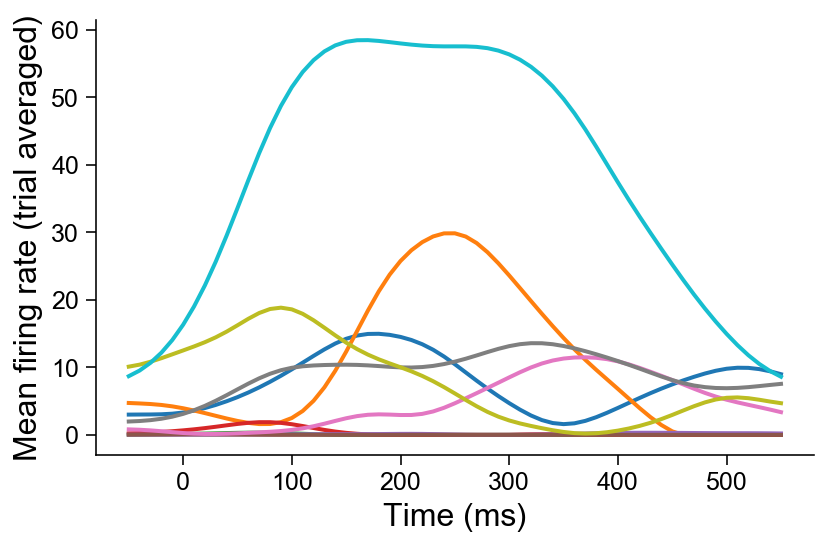

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(times, mfrate[19,:,:10]);
ax.set(xlabel='Time (ms)', ylabel='Mean firing rate (trial averaged)')

## Apply PCA

In [6]:
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(np.concatenate(mfrate), axis=0)
print(Z.shape)

n_pcs = 6
pca = PCA(n_components=n_pcs)
score = pca.fit_transform(Z)
score_tensor = score.reshape(C, T, n_pcs)
pca.explained_variance_


(6588, 218)


array([46.30973125, 21.3565962 , 15.71778826, 10.86137362,  9.46339958,
        7.89427638])

Text(0, 0.5, 'PC2')

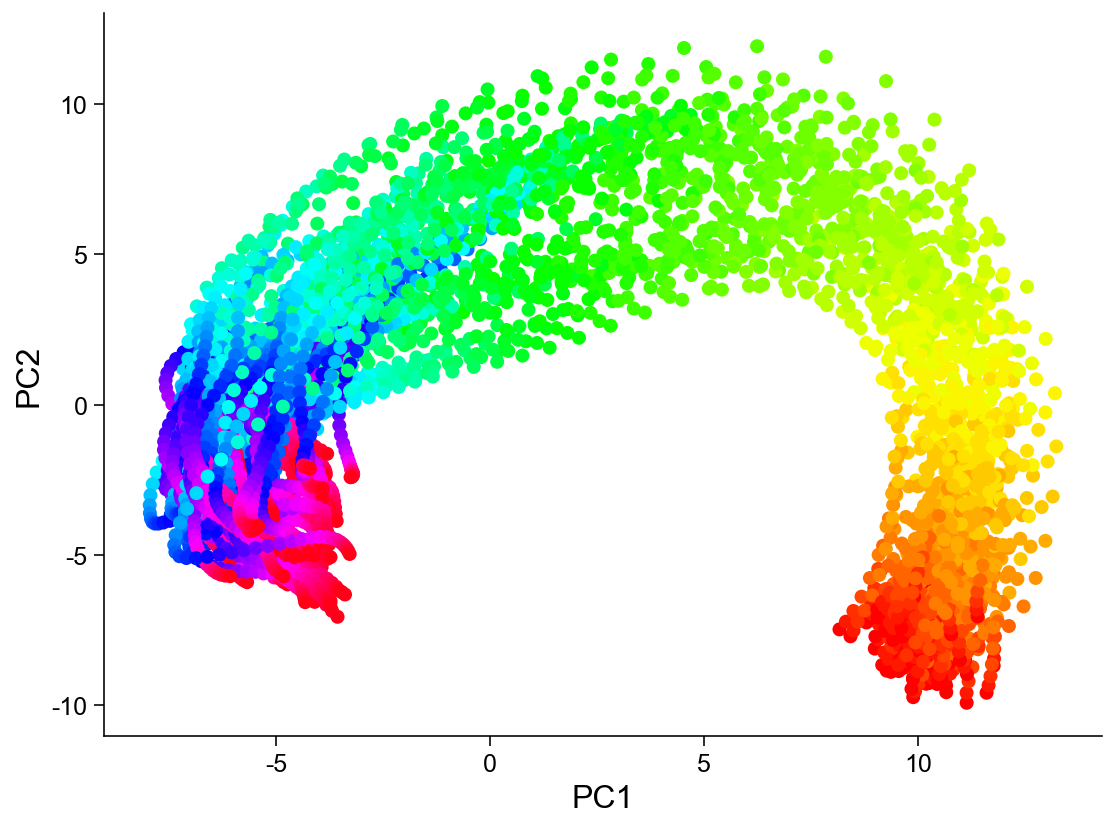

In [7]:
for i in range(C):
    plt.scatter(score_tensor[i,:,0], score_tensor[i,:,1], c=np.arange(score_tensor[0,:,0].shape[0]), cmap='hsv')
plt.xlabel('PC1')
plt.ylabel('PC2')

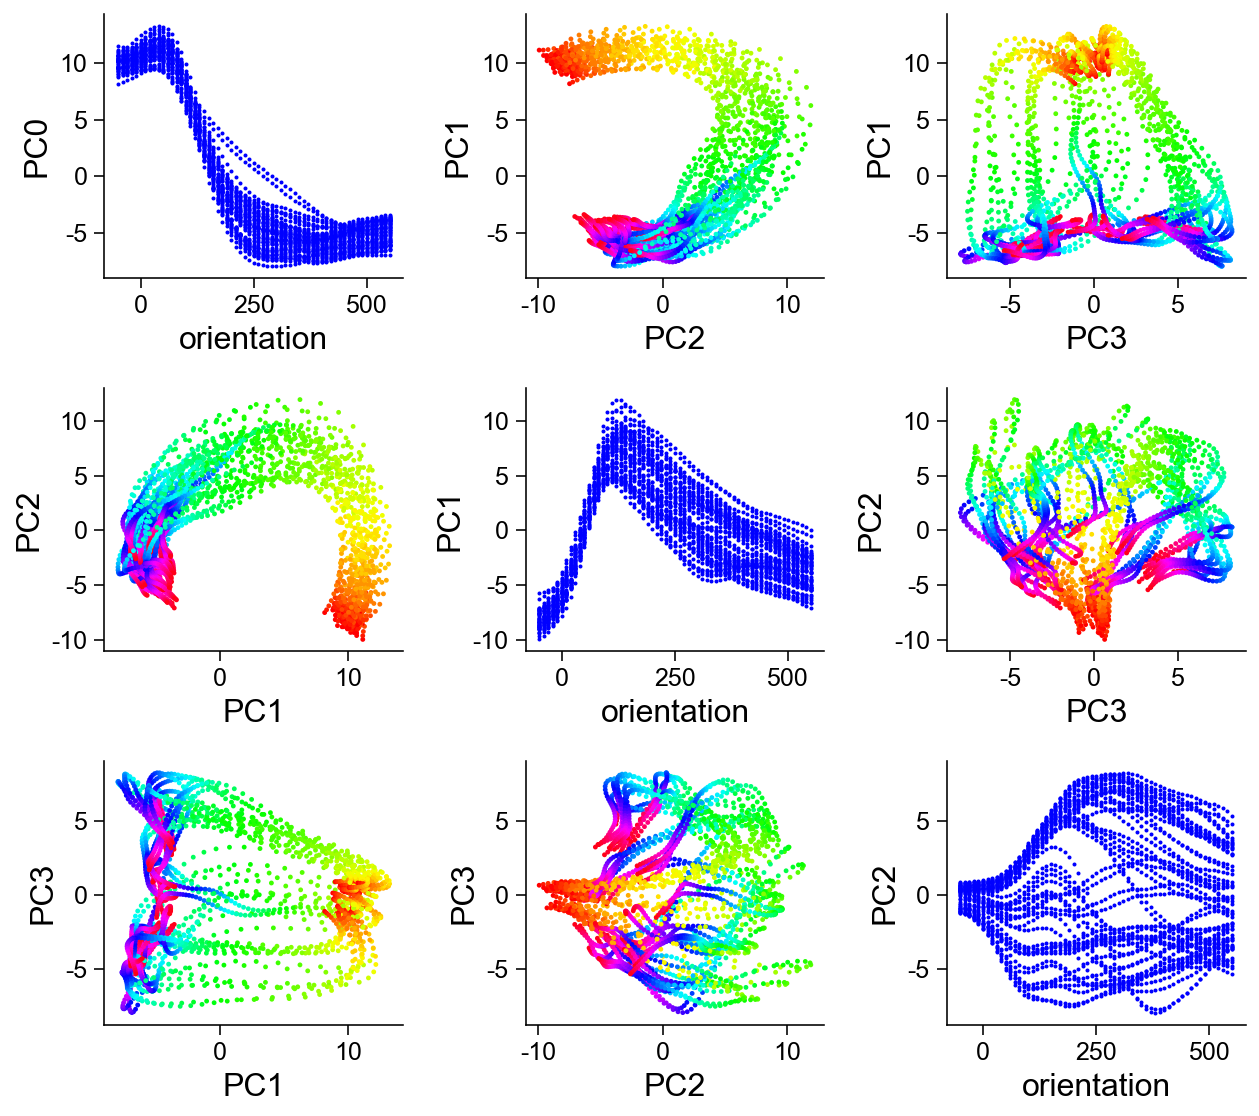

In [8]:
ncomp=3
fig, ax = plt.subplots(ncomp, ncomp, figsize=(9,8))
for i in range(ncomp):
    for j in range(ncomp):
        if i==j:
            for k in range(C//2):
                ax[i,j].scatter(times[:T], score_tensor[k,:,i], s  = 1, c='b')
            ax[i,j].set(xlabel=f'orientation', ylabel=f'PC{i:d}')
        else:
            for k in range(C//2):
                ax[i,j].scatter(score_tensor[k,:,j], score_tensor[k,:,i], c=np.arange(score_tensor[k,:,i].shape[0]), s=2, cmap='hsv')
            ax[i,j].set(xlabel=f'PC{j+1:d}', ylabel=f'PC{i+1:d}')

# A dynamical variation of PCA: jPCA


## Quick review of a simple dynamical model: Wilson Cowan Model
\begin{align}
&\frac{dr_E}{dt} = G_E(r_E,r_I)\\[0.5mm]
&\frac{dr_I}{dt} = G_I(r_E,r_I)
\end{align}
where

\begin{align}
&G_E(r_E,r_I) = \frac{1}{\tau_E} [-r_E + F_E(w_{EE}r_E -w_{EI}r_I + I^{\text{ext}}_E;a,\theta)]\\[1mm]
&G_I(r_E,r_I) = \frac{1}{\tau_I} [-r_I + F_I(w_{IE}r_E -w_{II}r_I + I^{\text{ext}}_I;a,\theta)]
\end{align}

$$ F(x;a,\theta) = \frac{1}{1+\text{e}^{-a(x-\theta)}} - \frac{1}{1+\text{e}^{a\theta}}$$

In [45]:
pars = default_pars(T=25.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8

pars['rE_init'], pars['rI_init'] = 0.5, 0.5
rE, rI = simulate_wc(**pars)

Text(0, 0.5, 'Activity')

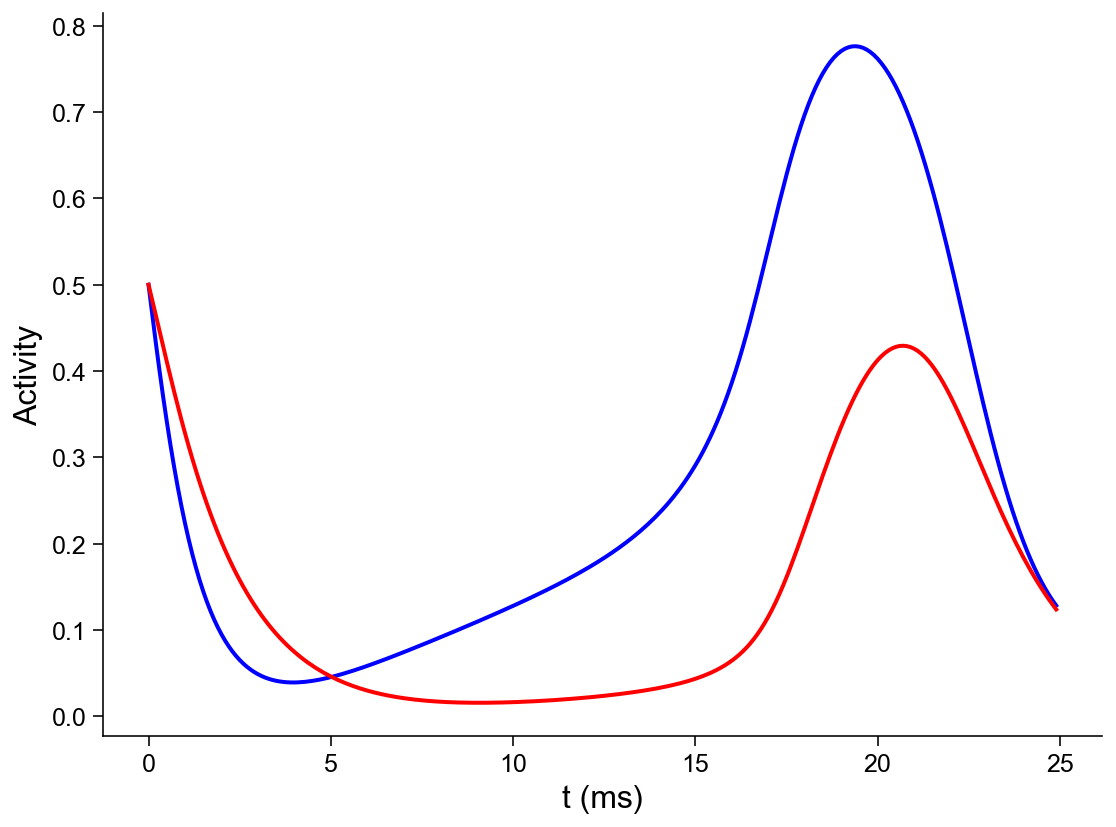

In [46]:
plt.plot(pars['range_t'], rE, 'b', label=r'$r_E$')
plt.plot(pars['range_t'], rI, 'r', label=r'$r_I$')
plt.xlabel('t (ms)')
plt.ylabel('Activity')

<AxesSubplot:>

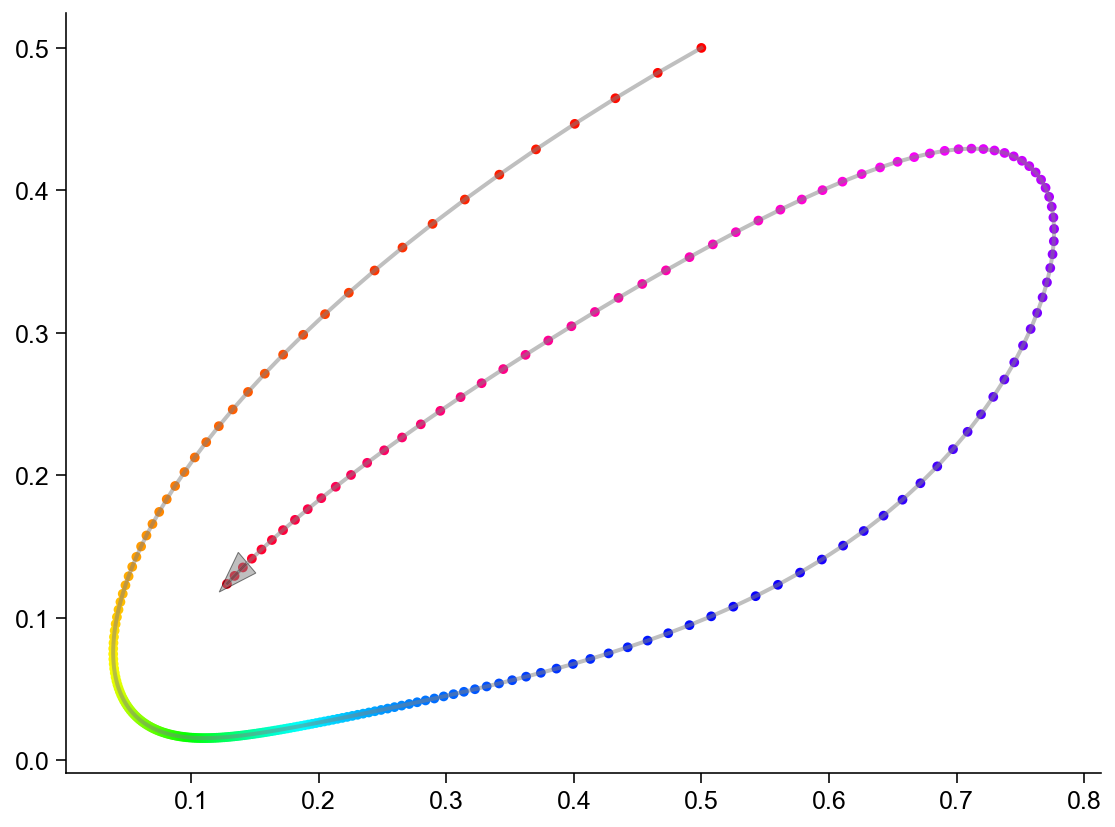

In [47]:
fig, ax = plt.subplots(1,1)
plot_trajectory(ax, rE, rI)


## Step 1: Data preprocessing

In [9]:
# zscore data:
Z = preprocess(mfrate, tmax=20)
T = Z.shape[1]
Z = np.concatenate(Z)

n_pcs = 6
pca = PCA(n_components=n_pcs)
score = pca.fit_transform(Z)
score_tensor = score.reshape(C, T, n_pcs)
pca.explained_variance_


array([0.54632724, 0.27439162, 0.212582  , 0.14474184, 0.12372174,
       0.08621534])

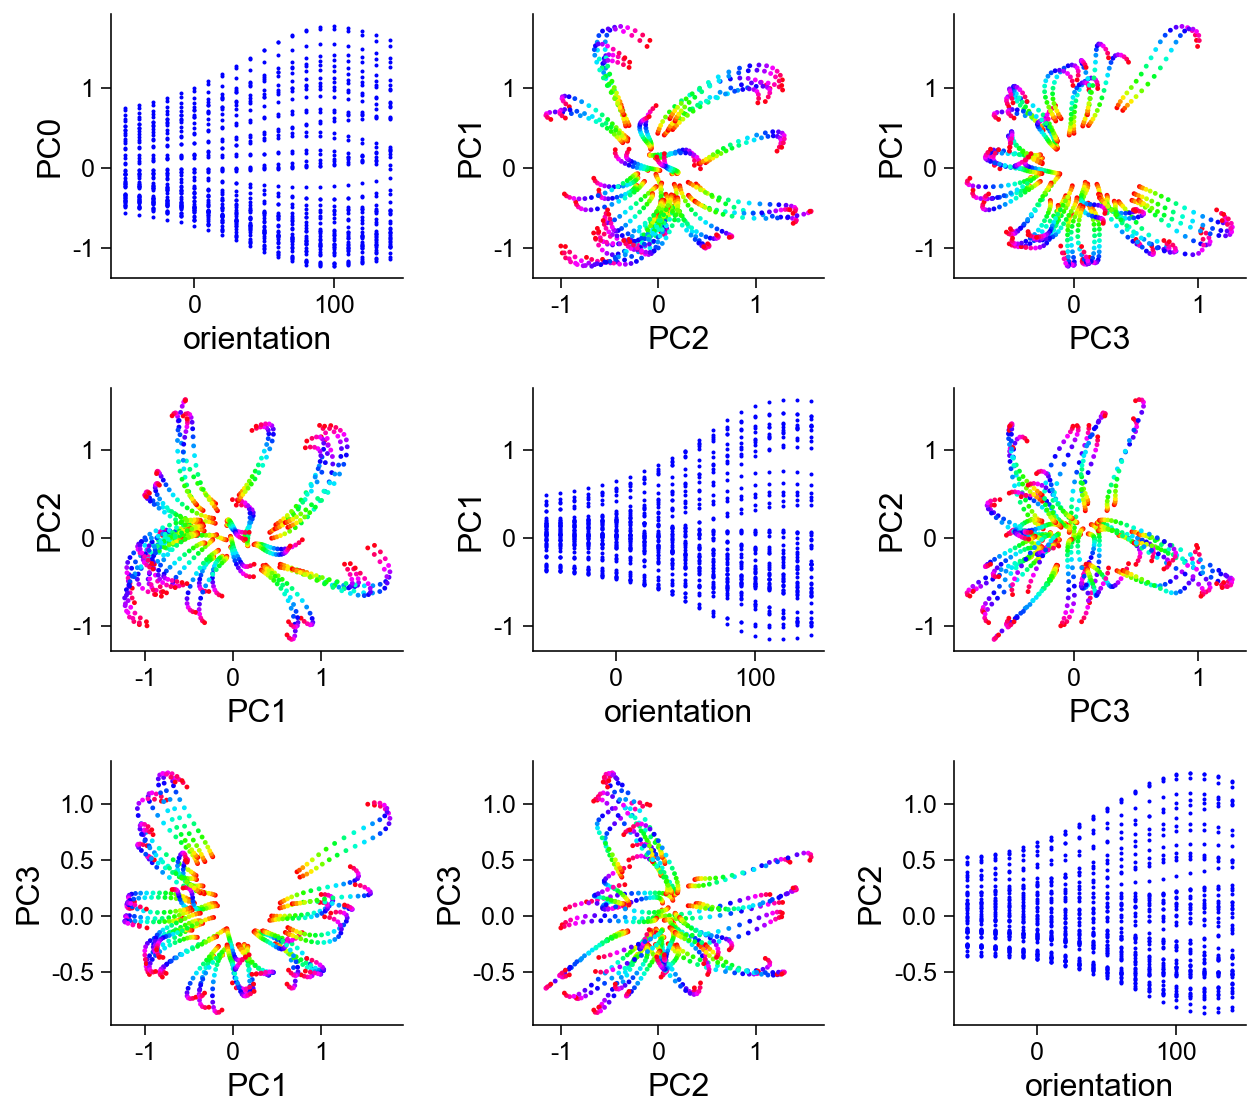

In [10]:
ncomp=3
fig, ax = plt.subplots(ncomp, ncomp, figsize=(9,8))
for i in range(ncomp):
    for j in range(ncomp):
        if i==j:
            for k in range(C//2):
                ax[i,j].scatter(times[:T], score_tensor[k,:,i], s  = 1, c='b')
            ax[i,j].set(xlabel=f'orientation', ylabel=f'PC{i:d}')
        else:
            for k in range(C//2):
                ax[i,j].scatter(score_tensor[k,:,j], score_tensor[k,:,i], c=np.arange(score_tensor[k,:,i].shape[0]), s=2, cmap='hsv')
            ax[i,j].set(xlabel=f'PC{j+1:d}', ylabel=f'PC{i+1:d}')

## Step 2: Construct the mapping to the change of states

$$
\dot{X}_{rad} = MX_{rad}
$$

In [11]:
# Using numerical difference to calculate change of X_rad
dscore_rad = np.concatenate(score_tensor[:,:-1,:] - score_tensor[:,1:,:])
score_rad = np.concatenate(score_tensor[:,:-1,:])

## Step 3: Solve the least square problem

$$
M^* = \argmin_{M\in \mathbb{R}^{n\times n}}\lVert\dot{X}_{rad} - MX_{rad}\rVert^2_{F}
$$


In [12]:
# perform least square
M = np.linalg.lstsq(score_rad, dscore_rad, rcond=None)[0]


**Skew symmetric regression**

For any matrix $M$, it can be decomposed into the summartion of a symmetric matrix and a skew matrix (anti-symmetric), as below
$$
M_{sym} = \frac{M+M^\top}{2}, \quad M_{skew} = \frac{M-M^\top}{2}.
$$

Recall the knowledge from linear algebra, we know that:
- $M_{sym}$ has **purely real** eigenvalues, and $M_{skew}$ has **purely imaginary** eigenvalues.
- $M_{sym}$ represents a linear transpormation of the ***stretching*** and ***compression***.
- $M_{skew}$ represents a linear transpormation of ***rotation***.

Here we want the to capture the rotational dynamics in the state space. Therefore, we modify the least square regression to a skew symmatric regression.
$$
M_{skew} = \argmin_{M\in \cancel{\mathbb{S}}^{n\times n}}\lVert\dot{X}_{rad} - MX_{rad}\rVert^2_{F}
$$

where $$M_{skew} = -M_{skew}^\top$$

In [ ]:
# M_skew = skew_sym_regress(score_rad, dscore_rad, )


## Step 4: Construct jPCA axis

Decompose $M$ into its eigenspaces. Since $M$ has purely imaginary eigenvalue, we can find pairs of eigenvectors with conjugated eigenvalues to form a 2-D eigen subspace. And in each 2-D eigen subspace, the frequencies of rotational dynamics are determined by the its magnitide of imaginary eigenvalues.

So here, we pick up the two conjugated eigenvalues with largest magnitude and their corresponding eigenvectors, $v_1$, $v_2$. Since $v_1$ and $v_2$ are complex vectors, we use them to build two real vectors as the real basis of 2-D rotational subspace. 

$$
u_1 = \frac{1}{\sqrt{2}}(v_1 + v_2), \quad u_2 = \frac{1}{\sqrt{2}}j(v_1 - v_2)
$$

In [13]:
# compute the eigenvalue of M
eigvals, eigvecs = np.linalg.eig(M)

# find the largest two imaginary eigenvalues and its corresponding eigenvectors.
order = np.flip(np.argsort(np.abs(np.imag(eigvals))))

eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# construct jPCs
jPCs = np.vstack((np.real(eigvecs[:,0]+eigvecs[:,1]), -np.imag(eigvecs[:,0]-eigvecs[:,1]))).T/np.sqrt(2)



## Step 5: Project original trajectory to jPCA axis

$$
X_{rad}^{jPCA} = 
\begin{bmatrix}
u_1^\top\\
u_2^\top\\
\end{bmatrix}
X_{rad}
$$

[Text(0.5, 0, 'jPC1'), Text(0, 0.5, 'jPC2')]

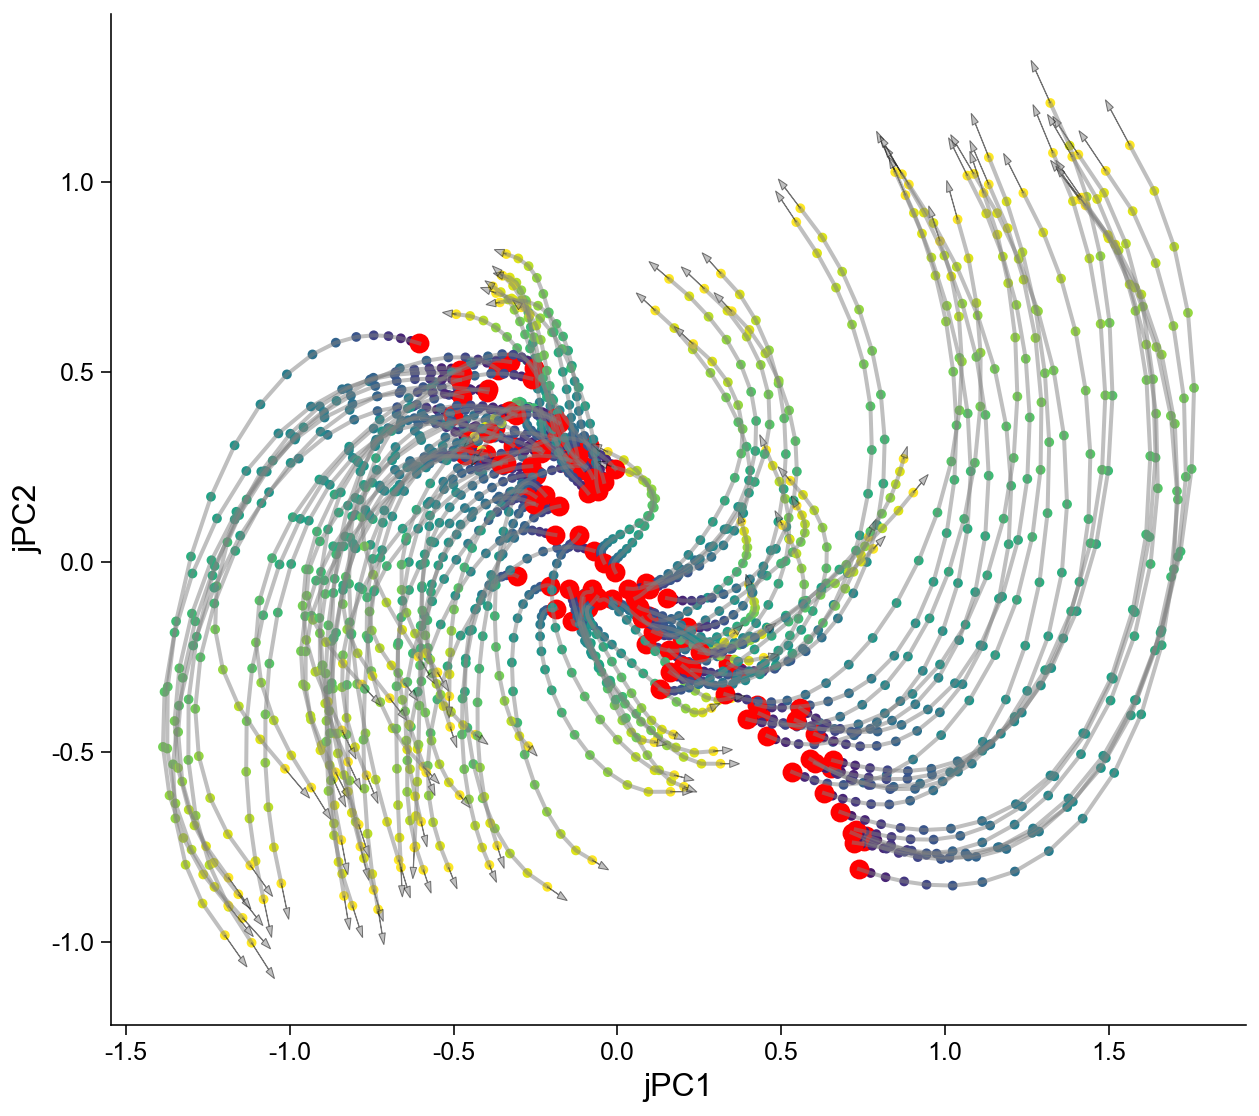

In [37]:
# project on jPCs
jPCA_score = score @ jPCs

# visualization
jPCA_score_tensor = jPCA_score.reshape(C, T, 2)
fig, ax = plt.subplots(1,1,figsize=(9,8))
for k in range(C):
    plot_trajectory(ax, jPCA_score_tensor[k,:,0], jPCA_score_tensor[k,:,1], cmap='viridis')
    ax.scatter(jPCA_score_tensor[k,0,0], jPCA_score_tensor[k,0,1], c='r', s=80)
ax.set(xlabel='jPC1', ylabel='jPC2')

**Observations about figure above:**

- Rotations the neural state are prevalent during reaching.
- Neural state rotates in the same direction across conditions.
- The rotation phase follows naturally from the preparatory state.
- State-space rotations do not directly related to reach curvatures.


# Summary

- PCA can be directedly applied on time series analysis of neuroal populations, but might not easy to explain.
- jPCA provides an explanable way to observe the data which might provide more dynamical insights.